# Assignment 1: Hidden Markov Model
### Author: Jacopo Raffi

## Introduction
The dataset used consists of 9358 instances of hourly averaged readings from a set of 5 metal oxide chemical sensors that are part of a multi-sensor air quality instrument. The data were collected between March 2004 and February 2005 and include missing values, which are indicated by the number -200.
The benzene column, labeled C6H6(GT), was selected for analysis because it has few missing values (366 w.r.t. to the total).
The first step after the preprocessing was to choose the best configuration of parameters, number of hidden states and emission distribution using a naive model selection.
Finally, the optimal state assignment of the last 25% of the sequence was computed using two different approaches: the Viterbi algorithm and the hidden state posterior.

## Data Preprocessing
The first step in this analysis was data processing. As mentioned earlier, the dataset contains missing values, which are indicated by the dummy value '-200'.
Interpolation was used where appropriate, specifically by averaging the previous and subsequent values only if they differed from -200. Otherwise, the value from the same hour of the previous day was used.

In [ ]:
import pandas as pd
import hmmlearn.hmm as hmm
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data = pd.read_csv("./data/AirQualityUCI.csv", sep=';')
data = data[['Date', 'Time', 'C6H6(GT)']] # for the assignment just need one sensor column

data = data.replace(',', '.', regex=True) # need to do this to convert numbers into float (values are written with ',' and not '.')
data['C6H6(GT)'] = data['C6H6(GT)'].astype(float)

n_missing_values = len(data[data['C6H6(GT)'] == -200])
first_missing_value = data[data['C6H6(GT)'] == -200].index[0]

print(f'Number of missing values: {n_missing_values}\nIndex of the first missing value: {first_missing_value}')

# Data Preprocessing
seq = data['C6H6(GT)'].to_numpy()
for i, elem in enumerate(seq): # no risk to go out of bound because the index of the first missing value is 524
    if elem == -200:
        if seq[i+1] == -200 or seq[i-1] == -200:
            seq[i] = seq[i - 24] # same hour day before
        else:
            seq[i] = mean([seq[i-1], seq[i+1]]) # interpolation

data['C6H6(GT)'] = seq

Number of missing values: 366
Index of the first missing value: 524


## Best HMM Configuration
To select the best HMM configuration, a naive model selection process was performed considering four possible number of hidden states and two emission distributions: Gaussian and mixture of Gaussians (specifically, two Gaussians). The model selection involved using 75% of the data for training and the remaining 25% for validation. Then, after selecting the best configuration, retraining was applied to the entire sequence.

In [ ]:
seq = data['C6H6(GT)'].to_numpy()
seq = seq.reshape(-1, 1) # reshape needed for hmmlearn, 1D sequence must be in this form: [[1], [2], [3]]
split_size = int(len(seq) * 0.25)

tr_seq = seq[:-split_size] # 75 % for traing set
val_seq = seq[-split_size:] # 25 % for validation set

results = {'Gaussian Tr Score': [],
           'Gaussian Val Score': [],
           'Gaussian Converged': [],
           'Mix Gaussian Tr Score': [],
           'Mix Gaussian Val Score': [],
           'Mix Gaussian Converged': [] }

h_states = [2, 3, 5, 7]

for state in h_states:
    gauss_model = hmm.GaussianHMM(n_components=state, n_iter=1000)
    mix_gauss_model = hmm.GMMHMM(n_components=state, n_iter=1000, n_mix=2)

    gauss_model.fit(tr_seq)
    mix_gauss_model.fit(tr_seq)

    results['Gaussian Tr Score'].append(gauss_model.score(tr_seq))
    results['Gaussian Val Score'].append(gauss_model.score(val_seq))
    results['Gaussian Converged'].append(gauss_model.monitor_.converged)

    results['Mix Gaussian Tr Score'].append(mix_gauss_model.score(tr_seq))
    results['Mix Gaussian Val Score'].append(mix_gauss_model.score(val_seq))
    results['Mix Gaussian Converged'].append(mix_gauss_model.monitor_.converged)

df = pd.DataFrame(results, index=h_states)
df.index.name = "Number of States"


In [ ]:
df

,Gaussian Tr Score,Gaussian Val Score,Gaussian Converged,Mix Gaussian Tr Score,Mix Gaussian Val Score,Mix Gaussian Converged
Number of States,,,,,,
2,-24302.743380,-7883.351192,True,-20757.616569,-6506.822315,True
3,-20055.438986,-6251.777317,True,-19640.949259,-6083.277204,True
5,-19020.900788,-5903.977596,True,-18508.176019,-5775.583869,True
7,-18131.788582,-5741.921683,True,-18016.660560,-5548.095769,True



The table shows that as the number of states increases, so does the log-likelihood. Overall, the mixture of Gaussians seems to perform slightly better than the Gaussian distribution.
Therefore, the final configuration on which the retraining is performed consists of 7 hidden states and mixture of Gaussians for the emission distribution.

In [ ]:
mix_gauss_model = hmm.GMMHMM(n_components=7, n_iter=1000, n_mix=2)
mix_gauss_model.fit(seq)

GMMHMM(covars_prior=array([[[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]]]),
       covars_weight=array([[[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]]]),
       means_prior=array([[[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
       n_components=7, n_iter=1000, n_mix=2,
       weights_prior=array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]]))

## Optimal State Assignment

In [ ]:
subseq_size = int(len(seq) * 0.25)
subseq = seq[-subseq_size:] # last 25 % of the sequence
v_log_prob, v_states = mix_gauss_model.decode(subseq, algorithm='viterbi')
mps_log_prob, mps_states = mix_gauss_model.decode(subseq, algorithm='map')

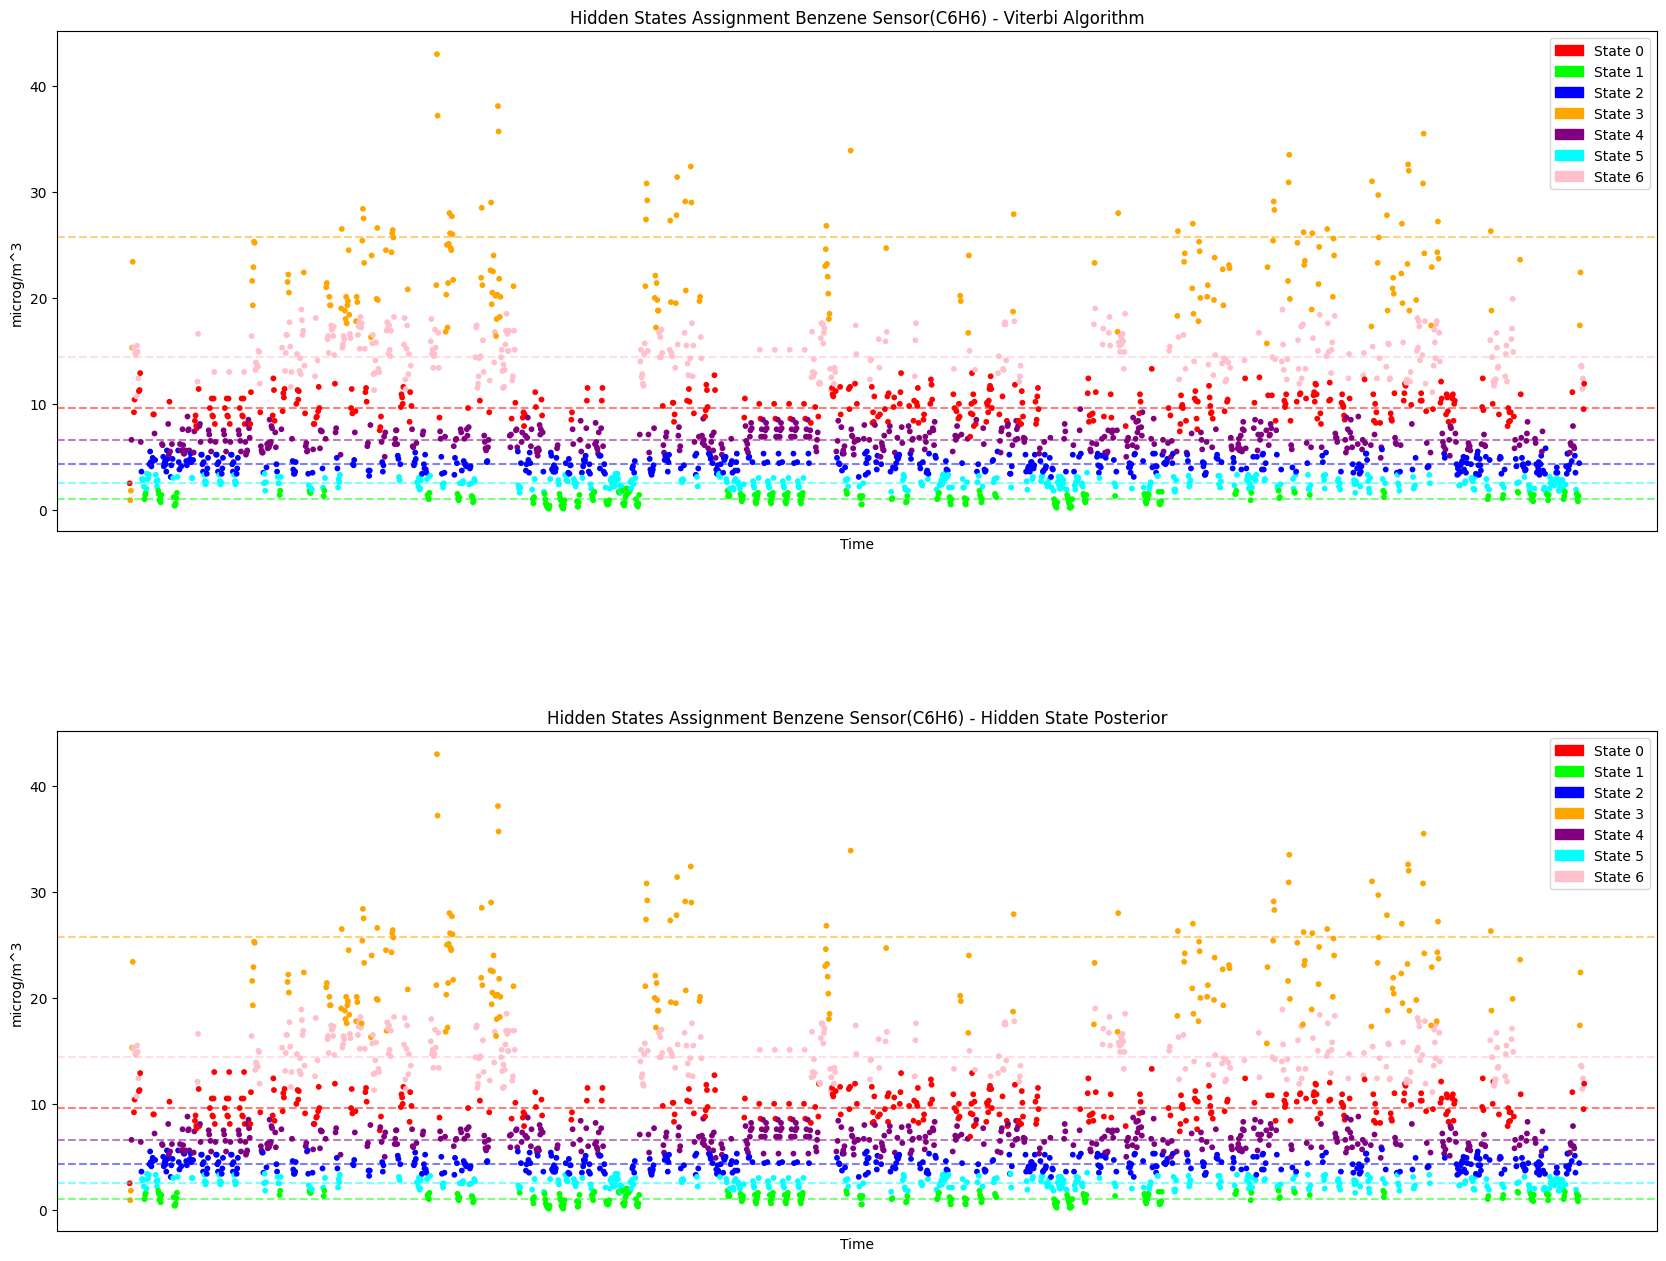

In [ ]:
states = 7

color_dict = {
    0: '#FF0000',
    1: '#00FF00',
    2: '#0000FF',
    3: '#FFA500',
    4: '#800080',
    5: '#00FFFF',
    6: '#FFC0CB'
}

labels = [f'State {i}' for i in range(states)] # labels for identify which color is which state

legend = [mpatches.Patch(color=color_dict[i], label=labels[i]) for i in range(states)] # legend to show in the plot

mps_colors = []
v_colors = []
for i, elem in enumerate(subseq):
  v_colors.append(color_dict[v_states[i]])
  mps_colors.append(color_dict[mps_states[i]])

# plot
fig, ax = plt.subplots(2, 1, figsize = (20,15))

for i, elem in enumerate(mix_gauss_model.means_): # plot the mean of the means of the two Guassians
  ax[0].axhline(y=mean((elem[0][0], elem[1][0])), linestyle='--', alpha=0.5, color=color_dict[i])
  ax[1].axhline(y=mean((elem[0][0], elem[1][0])), linestyle='--', alpha=0.5, color=color_dict[i])

ax[0].set_title("Hidden States Assignment Benzene Sensor(C6H6) - Viterbi Algorithm")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("microg/m^3")
ax[0].scatter(data.index[0: subseq_size], subseq, s=10, c=v_colors)
ax[0].legend(handles=legend)

ax[1].set_title("Hidden States Assignment Benzene Sensor(C6H6) - Hidden State Posterior")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("microg/m^3")
ax[1].scatter(data.index[0: subseq_size], subseq, s=10, c=mps_colors)
ax[1].legend(handles=legend)

ax[0].grid(False)
ax[1].grid(False)
ax[0].set_xticks([])
ax[1].set_xticks([])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

Comment the plot with the different 'clusters'(very-high, high, medium-high, medium, medium-low, low, very-low), how similar the two plots are (maybe local dependencies).

In [ ]:
count = 0
for v_state, mps_state in zip(v_states, mps_states):
    if v_state != mps_state:
        count += 1

print("Number of differences in State Assignment: ", count)

Number of differences in State Assignment:  37


## Appendix
Plot Transition matrix of the model

In [ ]:
def plot_transition_matrix(model, n_components):
    transition_matrix = model.transmat_

    # Plot the transition matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(transition_matrix, interpolation='nearest', cmap='Blues')
    plt.title(f'HMM Transition Matrix with {n_components} states')
    plt.colorbar(label='Probability')

    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            plt.text(j, i, '{:.4f}'.format(transition_matrix[i, j]), ha="center", fontsize=6, color='black')

    plt.grid(False)
    plt.xticks(np.arange(n_components), labels=np.arange(n_components))
    plt.yticks(np.arange(n_components), labels=np.arange(n_components))
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

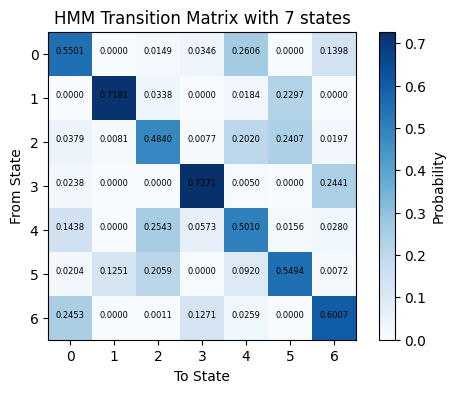

In [ ]:
plot_transition_matrix(mix_gauss_model, 7)

In [ ]:
for i, s_prob in enumerate(mix_gauss_model.startprob_):
    print(f'Prior Probability State {i}: {s_prob}') #State 0 is medium-high

Prior Probability State 0: 1.0
Prior Probability State 1: 0.0
Prior Probability State 2: 0.0
Prior Probability State 3: 0.0
Prior Probability State 4: 0.0
Prior Probability State 5: 0.0
Prior Probability State 6: 0.0


In [ ]:
data.iloc[0]

Date        10/03/2004
Time          18.00.00
C6H6(GT)          11.9
Name: 0, dtype: object